# Monte Carlo class usage

Finally the Monte Carlo simulations can be performed using a dedicated class called `MonteCarlo`.
Say goodbye to the long and tedious process of creating the Monte Carlo Simulations throughout jupyter notebooks.


In [85]:
# We import these lines for debugging purposes, only works on Jupyter Notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's import the necessary libraries, including the newest `MonteCarlo` class!


In [86]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, MonteCarlo, Function
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,
)
import datetime

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [87]:
%matplotlib inline

The `MonteCarlo` class allows to perform Monte Carlo simulations in a very simple way.
We just need to create an instance of the class, and then call the method `simulate()` to perform the simulations.

The class has a lot of capabilities, we try to over as much as possible in this example.
We encourage you to check the documentation of the class to learn more about it.

Additionally, you can check RocketPy's main reference for a better conceptual understanding
of the Monte Carlo Simulations: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](<https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331>)

## Step 1: Creating the Inputs for the Simulations


We will define rocketpy objects (e.g. Environment, SolidMotor, etc.) and use them to create the Monte Carlo simulation loop.

### Environment


Let's start by creating an Environment object, which will describe the atmospheric conditions for our launch site.

In [88]:
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))

As of the Atmospheric model, We will use an Ensemble model to a more accurate wind representation.
The Ensemble forecast is a different kind of forecast that uses multiple runs of the same model with slightly different initial conditions to represent the uncertainty in the forecast.

In [ ]:
env.set_atmospheric_model(type="Ensemble", file="GEFS")

For each rocketpy object, we will create a Stochastic object that works as an extension of the initial model, allow us to define what are the uncertainties of each input parameter.

In [89]:
mc_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
    wind_velocity_x_factor=(1.0, 0.33, "normal"),
    wind_velocity_y_factor=(1.0, 0.33, "normal"),
)

mc_env

StochasticEnvironment(object=<rocketpy.environment.environment.Environment object at 0x0000025FD4B24D00>, **kwargs)

In the example above, the

We can use the 

In [90]:
wind_x_at_1000m = []
for i in range(10):
    rnd_env = mc_env.create_object()
    wind_x_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_x_at_1000m)

[6.7455843995570115, 9.45206793555924, 7.133404365238797, 7.509209973085147, 7.080040289426364, 8.21168499811828, 6.69560540935254, 7.080040289426364, 6.166552798360079, 5.825449821486011]


### Motor


Let's define the motor using the firs method. We will be using the data from the manufacturer, and following
the [RocketPy's documentation](https://docs.rocketpy.org/en/latest/user/index.html).


In [91]:
motor = SolidMotor(
    thrust_source="../../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
motor.total_impulse

6026.35

In [92]:
mc_motor = StochasticSolidMotor(
    solid_motor=motor,
    thrust_source=[
        "../../../data/motors/Cesaroni_M1670.eng",
        [[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]],
        Function([[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]]),
    ],
    burn_start_time=(0, 0.1),
    grains_center_of_mass_position=0.001,
    grain_density=50,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(6500, 1000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)
mc_motor

StochasticSolidMotor(object=<rocketpy.motors.solid_motor.SolidMotor object at 0x0000025FD581B490>, **kwargs)

In [93]:
total_impulse = []
for i in range(10):
    rnd_motor = mc_motor.create_object()
    total_impulse.append(rnd_motor.total_impulse)

print(total_impulse)

[7830.5746832196755, 6026.725818972614, 7155.742383938769, 6812.498622694501, 6624.750100655547, 5980.990325705849, 7741.79509622779, 6652.021435515451, 6485.650255234743, 7438.312987888976]


### Rocket


In [94]:
rocket = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket.add_motor(motor, position=-1.255)

nose_cone = rocket.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../../data/calisto/NACA0012-radians.csv", "radians"),
)

tail = rocket.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

Additionally, we set parachutes for our Rocket, as well as the trigger functions for the deployment of such parachutes.


In [95]:
Main = rocket.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

In [96]:
mc_rocket = StochasticRocket(
    rocket=rocket,
    radius=0.0127 / 2000,
    mass=(15.426, 0.5, "normal"),
    inertia_11=(6.321, 0),
    inertia_22=0.01,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)
mc_rocket

StochasticRocket(object=<rocketpy.rocket.rocket.Rocket object at 0x0000025FD3ECD8D0>, **kwargs)

In [97]:
mc_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

mc_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)

mc_tail = StochasticTail(
    tail=tail,
    top_radius=0.001,
    bottom_radius=0.001,
    length=0.001,
)

mc_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons, buttons_distance=0.001
)

mc_main = StochasticParachute(
    parachute=Main,
    cd_s=0.1,
    lag=0.1,
)

mc_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.07,
    lag=0.2,
)

In [98]:
mc_rocket.add_motor(mc_motor, position=0.001)
mc_rocket.add_nose(mc_nose_cone, position=(1.134, 0.001))
mc_rocket.add_trapezoidal_fins(mc_fin_set, position=(0.001, "normal"))
mc_rocket.add_tail(mc_tail)
mc_rocket.set_rail_buttons(mc_rail_buttons, lower_button_position=(0.001, "normal"))
mc_rocket.add_parachute(mc_main)
mc_rocket.add_parachute(mc_drogue)

In [99]:
mc_rocket

StochasticRocket(object=<rocketpy.rocket.rocket.Rocket object at 0x0000025FD3ECD8D0>, **kwargs)

In [100]:
mc_rocket.last_rnd_dict

{}

In [101]:
for i in range(10):
    rnd_rocket = mc_rocket.create_object()
    print(rnd_rocket.static_margin(0))

2.5627561051925336
2.617290668737351
2.560601933572927
2.538692885664805
2.6275913143214042
2.6759407596247233
2.6843557054125515
2.6443890243669266
2.706910771724363
2.6384653033173406



### Flight


In [102]:
test_flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5,
    inclination=84,
    heading=133,
)

In [103]:
mc_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),
    heading=(53, 2),
)
mc_flight

StochasticFlight(object=<Flight(rocket= <rocketpy.rocket.rocket.Rocket object at 0x0000025FD3ECD8D0>, environment= <rocketpy.environment.environment.Environment object at 0x0000025FD4B24D00>, rail_length= 5, inclination= 84, heading = 133,name= Flight)>, **kwargs)

And we can visualize the flight trajectory:


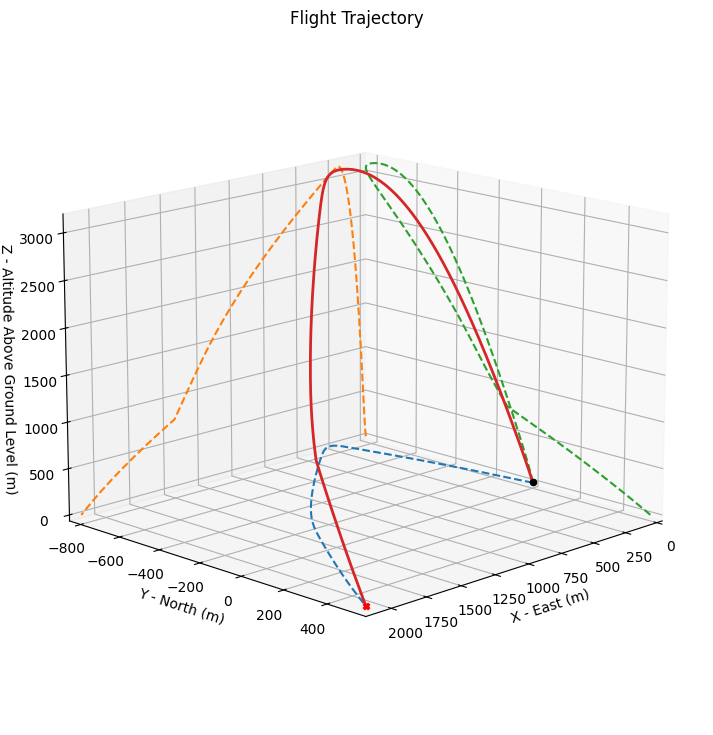

In [104]:
test_flight.plots.trajectory_3d()

### Step 2: Starting the Monte Carlo Simulations


First, let's invoke the `MonteCarlo` class, we only need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.


In [105]:
test_dispersion = MonteCarlo(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example",
    environment=mc_env,
    rocket=mc_rocket,
    flight=mc_flight,
)

# TODO: add custom warning o when the rocket doesn't have a motors, parachute, or AeroSurface

The following input file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.inputs.txt
A total of 417 simulations results were loaded from the following output file: monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt

The following error file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.errors.txt


Then, we can run the simulations using the method `MonteCarlo.simulate()`.
But before that, we need to set some simple parameters for the simulations.
We will set them by using a dictionary, which is one of the simplest way to do it.


Finally, let's iterate over the simulations and export the data from each flight simulation!


In [107]:
test_dispersion.simulate(number_of_simulations=1000, append=False)

Completed 1000 iterations. Total CPU time: 786.7 s. Total wall time: 1343.6 sime left: 0 s   
Saving results.
Results saved to monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt


### Visualizing the results


Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.


First, we can print numerical information regarding the results of the simulations.


In [108]:
# only need to import results if you did not run the simulations
# test_dispersion.import_results()

In [109]:
test_dispersion.num_of_loaded_sims

1000

In [110]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_analysis_outputs/monte_carlo_class_example
Number of simulations:  1000
Results: 

                Parameter            Mean       Std. Dev.
------------------------------------------------------------
                 y_impact        1366.088         296.630
                  t_final         303.689          36.535
     out_of_rail_velocity          24.031           2.556
                 apogee_x         112.427         127.288
     frontal_surface_wind           5.871           0.618
          max_mach_number           0.849           0.139
                   apogee        3380.915         661.004
              apogee_time          25.722           2.184
                 apogee_y          -9.327         112.629
         out_of_rail_time           0.366           0.068
          impact_velocity          -5.337           0.081
     lateral_surface_wind           0.661           0.644
                 x_impact        2494.958

Secondly, we can plot the results of the simulations.


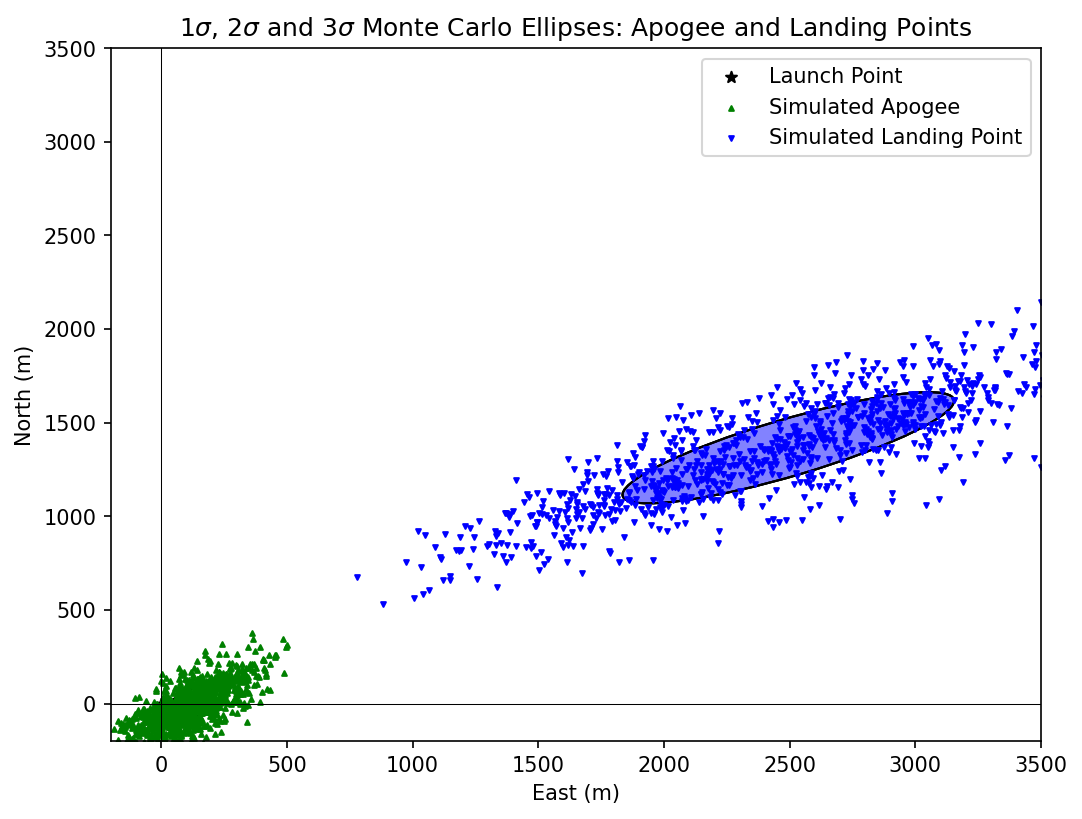

In [111]:
test_dispersion.plots.ellipses(xlim=(-200, 3500), ylim=(-200, 3500))

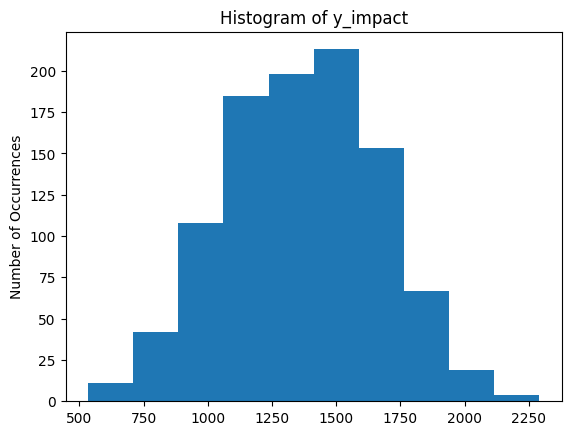

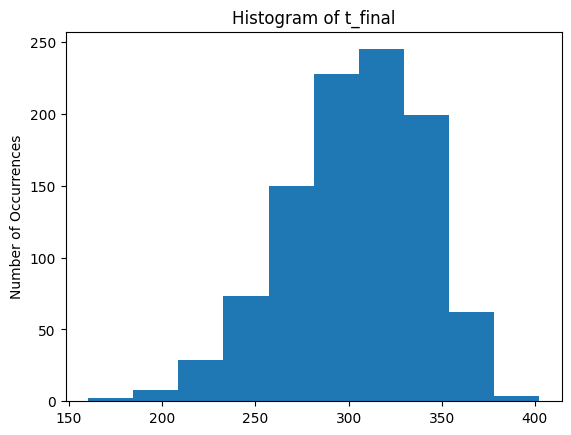

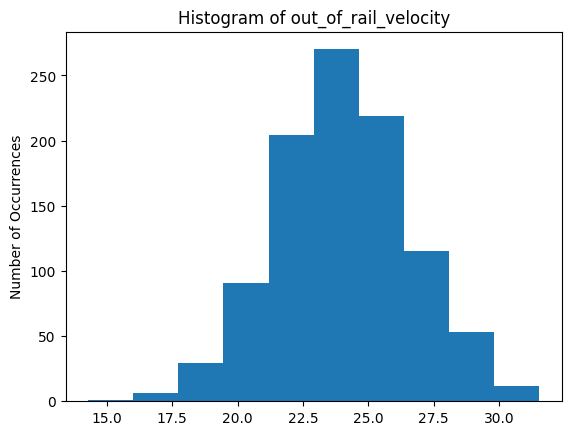

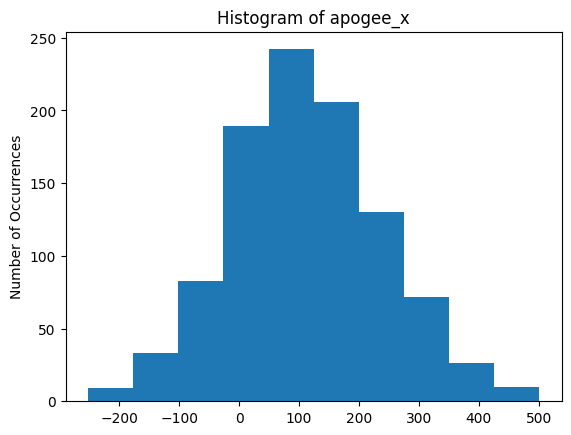

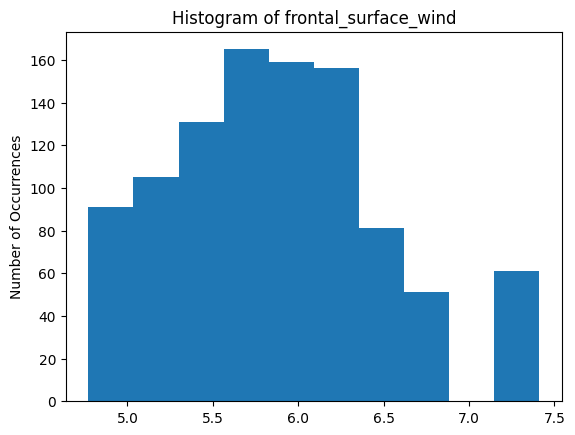

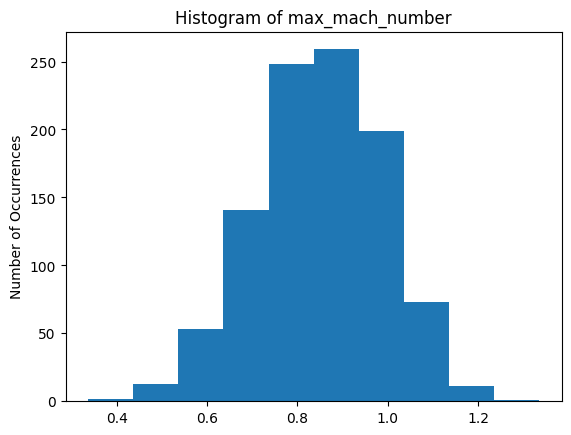

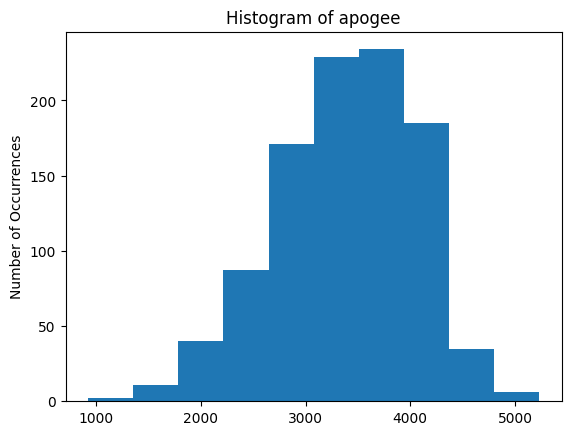

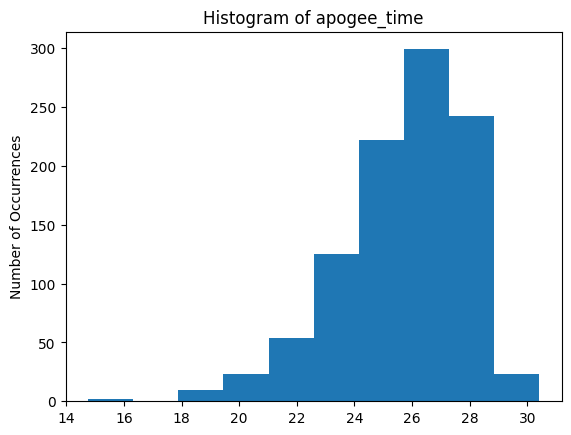

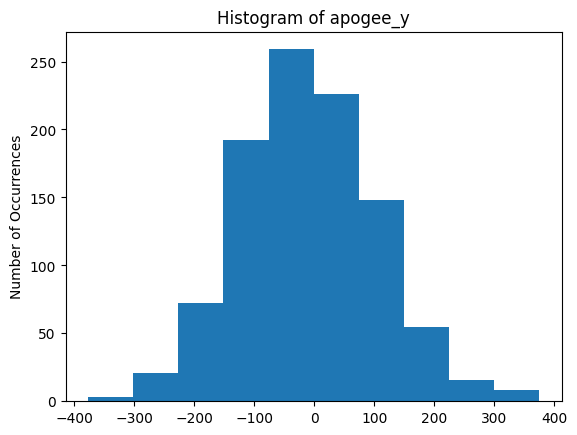

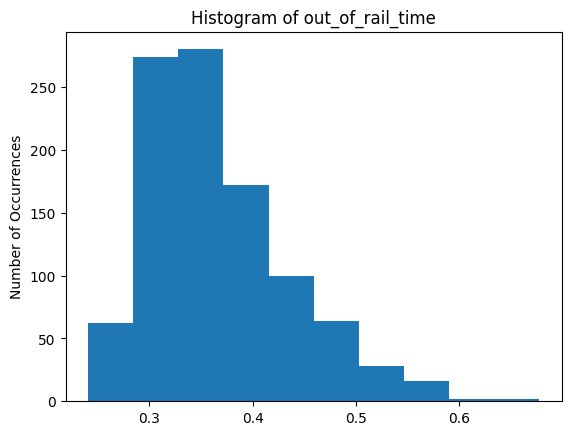

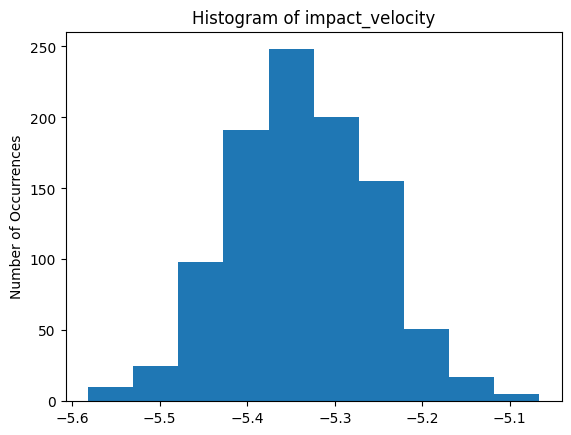

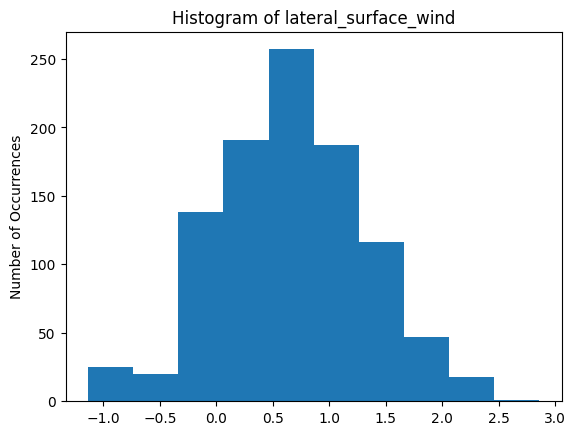

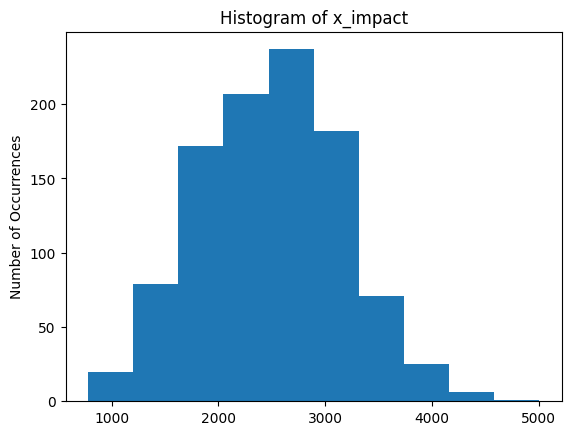

In [114]:
test_dispersion.plots.all()

Finally, one may also export to kml so it can be visualized in Google Earth


In [113]:
test_dispersion.export_ellipses_to_kml(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)